# ResNet50 Model 

In [2]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

# Custom Dependencies (for ResNet50)
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices: 
    print("GPU is available") 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available") 

GPU is not available


### Load and Pre-process FER2013 Dataset

In [4]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

# Define the Image Size and Parameters
img_size = (48, 48)
input_shape = (48, 48, 3)
batch_size = 64

## Trial #3: ResNet50 with Pretrained Weights

### Create Data Generators 

In [5]:
# Data Preprocessing and augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator 
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 17118 images belonging to 4 classes.
Found 3019 images belonging to 4 classes.
Found 5003 images belonging to 4 classes.


### Load ResNet50 Base with ImageNet Weights

In [6]:
# Add class weights 
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
# Define ResNet50V2 model (pretrained w/ Imagenet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model (for now)
for layer in base_model.layers:
    layer.trainable = False

### Define the ResNet Model

In [8]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=base_model.input, outputs=output)

In [9]:
# Create a loss function that is appropriate for multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the ResNet Model 
model_3.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy'])

initial_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

### Train the Model

#### Phase 1: Inital Training

In [10]:
# Start the initial training
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.2635 - loss: 1.4582 - val_accuracy: 0.2382 - val_loss: 1.3900 - learning_rate: 0.0010
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.2368 - loss: 1.3863 - val_accuracy: 0.2037 - val_loss: 1.3886 - learning_rate: 0.0010
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - accuracy: 0.2235 - loss: 1.3851 - val_accuracy: 0.1984 - val_loss: 1.3873 - learning_rate: 0.0010
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - accuracy: 0.2211 - loss: 1.3848 - val_accuracy: 0.2040 - val_loss: 1.3871 - learning_rate: 0.0010
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.2154 - loss: 1.3839 - val_accuracy: 0.1981 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.2277 - loss: 1.3904 - val_accuracy: 0.2398 - val_loss: 1.3868 - learning_rate: 0.0010
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.2902 - loss:

#### Phase 2: Final Training (unfreeze and fine-tune)

In [11]:
# Fine-tune the model (unfreeze the last 50% of ResNet50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True


# Compile (adding a lower learning rate)
model_3.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss_fn,
              metrics=['accuracy'])

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Continue training (fine-tune entire model)
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 126s 457ms/step - accuracy: 0.2532 - loss: 1.4672 - val_accuracy: 0.2435 - val_loss: 1.3904 - learning_rate: 1.0000e-05
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 122s 457ms/step - accuracy: 0.2540 - loss: 1.4269 - val_accuracy: 0.2524 - val_loss: 1.4007 - learning_rate: 1.0000e-05
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 125s 466ms/step - accuracy: 0.2608 - loss: 1.4079 - val_accuracy: 0.3177 - val_loss: 1.3742 - learning_rate: 1.0000e-05
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 122s 453ms/step - accuracy: 0.2870 - loss: 1.3960 - val_accuracy: 0.2868 - val_loss: 1.3795 - learning_rate: 1.0000e-05
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 119s 443ms/step - accuracy: 0.2732 - loss: 1.3944 - val_accuracy: 0.3319 - val_loss: 1.3630 - learning_rate: 1.0000e-05
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 124s 463ms/step - accuracy: 0.2892 - loss: 1.3882 - val_accuracy: 0.2541 - val_loss: 1.3897 - learning_rate: 1.0000e-05
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# # Save the weights
# model_3.save_weights('ResNet50_weights.weights.h5')

### Evaluate

In [ ]:
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.3286 - loss: 1.3279
Final Test Accuracy: 0.3874
Final Test Loss: 1.3060


### Plot Training History 

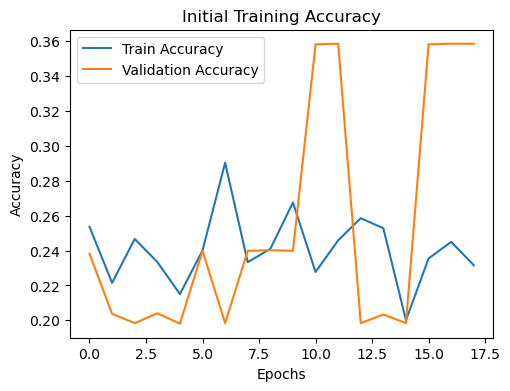

In [ ]:
# Plotting the model accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

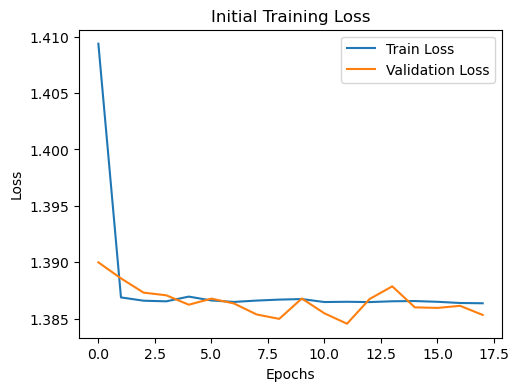

In [ ]:
# Plotting the model loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Question: Was this model successful?** 

**Answer:** No, the ResNet50 model was not successful in achieving the desired performance. Despite completing training, it reached only 40% accuracy, which is well below the target benchmark of 75% for reliable multi-class emotion classification. The final loss was approximately 1.68 (or 168%), indicating that the model's predictions lacked consistency and confidence. The model may not have been fully fine-tuned, freezing too many layers limits the ability to learn emotion-specific features. Emotion recognition requires detecting subtle facial cues, and ResNet50 (originally designed for general object detection) may not be optimized for this type of task out of the box.
* Accuracy: 
* Loss:

## Model #4: ResNet50V2 

### Re-Define Data Generators 

In [ ]:
# Re-define parameters 
img_size = (48, 48)
batch_size = 64
num_classes = 4

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # Use 15% of training data for validation
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',  # ResNet50V2 expects 3-channel RGB images
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 17118 images belonging to 4 classes.
Found 3019 images belonging to 4 classes.
Found 5003 images belonging to 4 classes.


### Load ResNet50V2 (saved & pretrained weights)

In [18]:
# Define the model architecture 
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 emotion classes

model_4 = Model(inputs=base_model.input, outputs=output)

In [19]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False# Freeze the base model layers

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,827,588 (90.90 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [20]:
# Callbacks for training
callbacks_training = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [22]:
# Train the model (custom head only)
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training
)

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.3887 - loss: 1.3299 - val_accuracy: 0.4036 - val_loss: 1.2919 - learning_rate: 1.0000e-04
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4688 - loss: 1.3106 - val_accuracy: 0.4039 - val_loss: 1.2861 - learning_rate: 1.0000e-04
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.4054 - loss: 1.3008 - val_accuracy: 0.4166 - val_loss: 1.2868 - learning_rate: 1.0000e-04
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4688 - loss: 1.3223 - val_accuracy: 0.4116 - val_loss: 1.2871 - learning_rate: 1.0000e-04
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.4023 - loss: 1.3051 - val_accuracy: 0.4302 - val_loss: 1.2703 - learning_rate: 1.0000e-04
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4219 - loss: 1.2661 - val_accuracy: 0.4199 - val_loss: 1.2798 - learning_rate: 1.0000e-04
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/st

In [23]:
# Unfreeze some layers for fine-tuning (in base model)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_4.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training,
)

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 45s 159ms/step - accuracy: 0.3405 - loss: 1.3822 - val_accuracy: 0.3873 - val_loss: 1.3178 - learning_rate: 1.0000e-05
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3281 - loss: 1.3548 - val_accuracy: 0.3979 - val_loss: 1.3155 - learning_rate: 1.0000e-05
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.3813 - loss: 1.3322 - val_accuracy: 0.3986 - val_loss: 1.3032 - learning_rate: 1.0000e-05
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4688 - loss: 1.2167 - val_accuracy: 0.4092 - val_loss: 1.2957 - learning_rate: 1.0000e-05
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 49s 182ms/step - accuracy: 0.3931 - loss: 1.3181 - val_accuracy: 0.4072 - val_loss: 1.2897 - learning_rate: 1.0000e-05
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4219 - loss: 1.2412 - val_accuracy: 0.4129 - val_loss: 1.2827 - learning_rate: 1.0000e-05
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 49s 182ms/st

### Evaluate 

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_4.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.3053 - loss: 1.3755
Test Loss: 1.2274, Test Accuracy: 0.4545


In [ ]:
# # Save the weights
# model_4.save_weights('ResNet50V2_weights.weights.h5')